In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = sns.load_dataset("diamonds")
df.head()



,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


# TASK1

In [ ]:
#selecting numerical columns for correlation analysis
df_numeric = df.select_dtypes(include=[np.number])
print("\n numerical columns for correlation analysis:\n", df_numeric.columns.tolist())


 numerical columns for correlation analysis:
 ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


In [ ]:
#computing  the correlation matrix
print("\nComputing correlation matrix...\n")
correlation_matrix = df_numeric.corr()
correlation_matrix


Computing correlation matrix...



,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


In [ ]:
#highly correlated features (threshold > 0.85)
print("\nhighly correlated features (threshold > 0.85)...\n")
high_corr_pairs = set()
threshold = 0.85

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.add((col1, col2))
            print(f"Highly correlated pair: {col1} - {col2} (Correlation = {correlation_matrix.iloc[i, j]:.2f})")


highly correlated features (threshold > 0.85)...

Highly correlated pair: price - carat (Correlation = 0.92)
Highly correlated pair: x - carat (Correlation = 0.98)
Highly correlated pair: x - price (Correlation = 0.88)
Highly correlated pair: y - carat (Correlation = 0.95)
Highly correlated pair: y - price (Correlation = 0.87)
Highly correlated pair: y - x (Correlation = 0.97)
Highly correlated pair: z - carat (Correlation = 0.95)
Highly correlated pair: z - price (Correlation = 0.86)
Highly correlated pair: z - x (Correlation = 0.97)
Highly correlated pair: z - y (Correlation = 0.95)


In [ ]:
#droping one feature from each correlated pair
features_to_drop = {pair[1] for pair in high_corr_pairs}  # droping second feature of each pair
print("\nthese correlated features to reduce multicollinearity:", features_to_drop)
df_reduced = df_numeric.drop(columns=features_to_drop)



these correlated features to reduce multicollinearity: {'y', 'price', 'x', 'carat'}


In [ ]:
# Recompute the correlation matrix after dropping correlated features
print("\n Recomputing correlation matrix after dropping correlated features...\n")
correlation_matrix_reduced = df_reduced.corr()
correlation_matrix_reduced


 Recomputing correlation matrix after dropping correlated features...



,depth,table,z
depth,1.000000,-0.295779,0.094924
table,-0.295779,1.000000,0.150929
z,0.094924,0.150929,1.000000


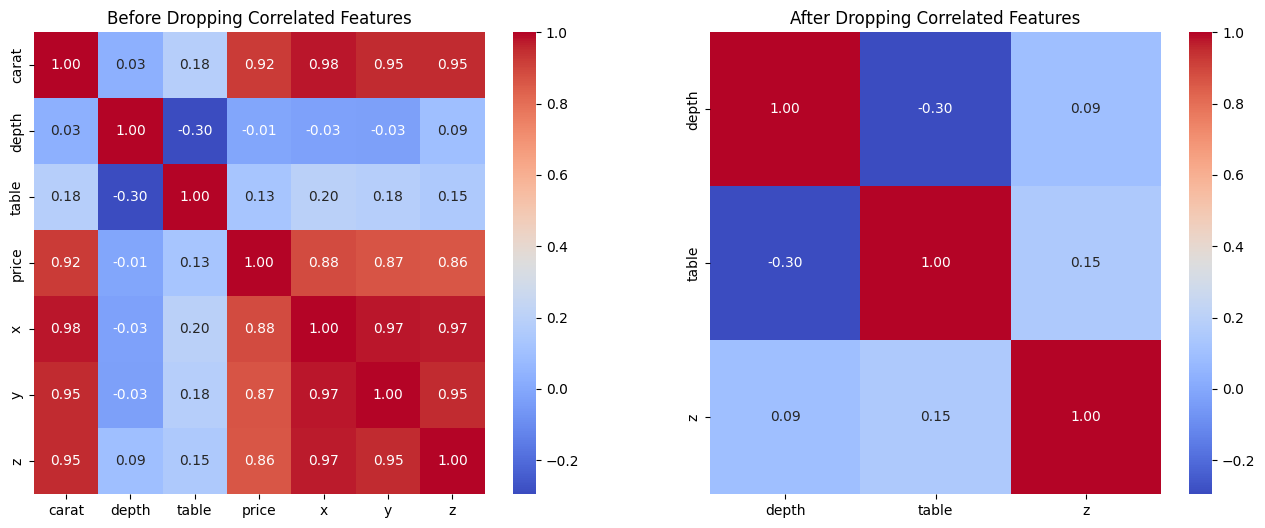

In [ ]:

# Visualization correlation matrices before and after using heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#before dropping features
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
axes[0].set_title("Before Dropping Correlated Features")

# After dropping features
sns.heatmap(correlation_matrix_reduced, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
axes[1].set_title("After Dropping Correlated Features")

plt.show()

# TASK2

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#encoding the categorical features
df['cut'] = LabelEncoder().fit_transform(df['cut'])
y = df['cut']
X = df_numeric.drop(columns=['cut'], errors='ignore')

#standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



In [ ]:
#1.SelectKBest (f_classif & mutual_info_classif)
print("\nFeature Selection using SelectKBest")
k = 3  #top 5 features

# Using f_classif (ANOVA F-value)
selector_f_classif = SelectKBest(score_func=f_classif, k=k)
X_new_f = selector_f_classif.fit_transform(X_train, y_train)
selected_features_f = X.columns[selector_f_classif.get_support()]
print("Top features using f_classif:", selected_features_f.tolist())

# Using mutual_info_classif
selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
X_new_mi = selector_mi.fit_transform(X_train, y_train)
selected_features_mi = X.columns[selector_mi.get_support()]
print("Top features using mutual_info_classif:", selected_features_mi.tolist())





Feature Selection using SelectKBest
Top features using f_classif: ['carat', 'depth', 'table']
Top features using mutual_info_classif: ['depth', 'table', 'x']


In [ ]:
#2. Recursive Feature Elimination (RFE) with Logistic Regression
print("\nFeature Selection using RFE with Logistic Regression")
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(log_reg, n_features_to_select=k)
X_rfe = rfe.fit_transform(X_train, y_train)
selected_features_rfe = X.columns[rfe.support_]
print("Top features using RFE:", selected_features_rfe.tolist())




Feature Selection using RFE with Logistic Regression
Top features using RFE: ['x', 'y', 'z']


In [ ]:
#3. Model-based Selection using Random Forest (SelectFromModel)
print("\n🔹 Feature Selection using Random Forest")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
selector_rf = SelectFromModel(rf, prefit=True, threshold='mean')
X_rf = selector_rf.transform(X_train)
selected_features_rf = X.columns[selector_rf.get_support()]
print("Top features using Random Forest:", selected_features_rf.tolist())


🔹 Feature Selection using Random Forest
Top features using Random Forest: ['depth', 'table']


In [ ]:
#Compare selected features #
print("\n🔹 Comparing selected features from all methods:")
feature_sets = {
    "f_classif": set(selected_features_f),
    "mutual_info_classif": set(selected_features_mi),
    "RFE": set(selected_features_rfe),
    "Random Forest": set(selected_features_rf)
}
for method, features in feature_sets.items():
    print(f"{method}: {features}")



🔹 Comparing selected features from all methods:
f_classif: {'depth', 'table', 'carat'}
mutual_info_classif: {'depth', 'table', 'x'}
RFE: {'y', 'z', 'x'}
Random Forest: {'depth', 'table'}


In [ ]:
# Train and Evaluate Logistic Regression using selected features
def train_and_evaluate(selected_features):
    X_train_selected = X_train[:, [X.columns.get_loc(f) for f in selected_features]]
    X_test_selected = X_test[:, [X.columns.get_loc(f) for f in selected_features]]
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    return accuracy_score(y_test, y_pred)

print("\n🔹 Evaluating Logistic Regression Performance:")
accuracy_scores = {}
for method, features in feature_sets.items():
    accuracy = train_and_evaluate(features)
    accuracy_scores[method] = accuracy
    print(f"{method} Accuracy: {accuracy:.4f}")




🔹 Evaluating Logistic Regression Performance:
f_classif Accuracy: 0.6061
mutual_info_classif Accuracy: 0.6080
RFE Accuracy: 0.4952
Random Forest Accuracy: 0.6203


In [ ]:
# Summarizing Best Feature Set
best_method = max(accuracy_scores, key=accuracy_scores.get)
print(f"\n🔹 Best feature selection method: {best_method} with accuracy {accuracy_scores[best_method]:.4f}")



🔹 Best feature selection method: Random Forest with accuracy 0.6203


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Task 3

In [ ]:
#Recursive Feature Elimination with Cross-Validation (RFECV)
print("\n Performing RFECV with Logistic Regression")
rfecv = RFECV(estimator=LogisticRegression(max_iter=1000), step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train, y_train)
optimal_features = X.columns[rfecv.support_]
print(f"Optimal number of features: {rfecv.n_features_}")
print("Selected features using RFECV:", optimal_features.tolist())




🔹 Performing RFECV with Logistic Regression
Optimal number of features: 7
Selected features using RFECV: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


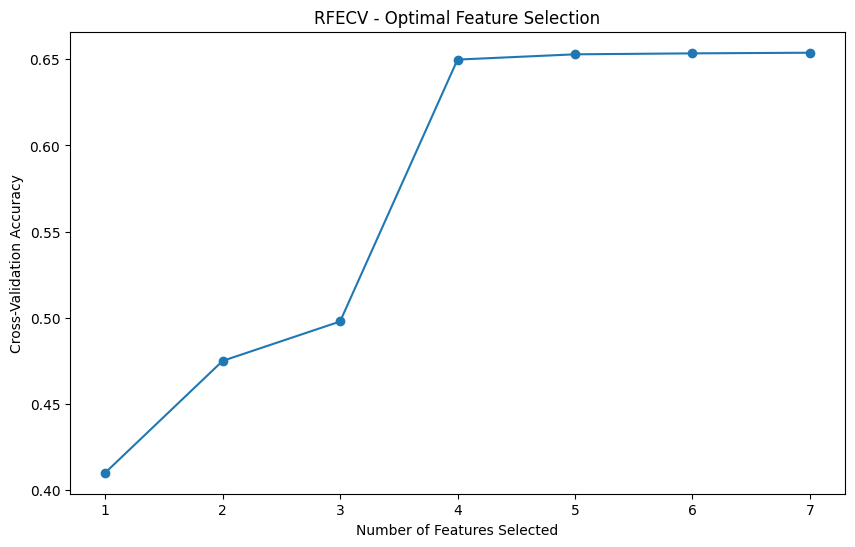

In [ ]:
# Plot RFECV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Accuracy")
plt.title("RFECV - Optimal Feature Selection")
plt.show()


In [ ]:
# Train models using different feature sets
def train_and_evaluate_full():
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

rfecv_accuracy = train_and_evaluate(optimal_features)
full_accuracy = train_and_evaluate_full()
f_classif_accuracy = accuracy_scores["f_classif"]

print("\n🔹 Comparing Model Performance:")
print(f"RFECV-selected features Accuracy: {rfecv_accuracy:.4f}")
print(f"All features Accuracy: {full_accuracy:.4f}")
print(f"SelectKBest (f_classif) Accuracy: {f_classif_accuracy:.4f}")


🔹 Comparing Model Performance:
RFECV-selected features Accuracy: 0.6587
All features Accuracy: 0.6587
SelectKBest (f_classif) Accuracy: 0.6061
